In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_context("talk")

# A. *Business Understanding*

*Gallup*, a global analytics and advice firm, plans to conduct a large-scale survey regarding the trends in public sentiment towards the political parties in the United States. In order to achieve this, they require a model that can rate the sentiment of a Tweet based on its content. Once training of the model has been completed, it is to be deployed as a sentiment analysis tool for that recieves data from the Twitter API.


# B. *Data Understanding*

## B.1 - Overview of the *Sentiment140* Dataset

> *The [Sentiment140](http://help.sentiment140.com/home) dataset will be used to train the classification model. It is a collection of $1,600,000$ tweets, all of which are labelled with a corresponding value indicating sentiment.*

> __The dataset consists of 5 input features and 1 target variable:__
> * __id__ *[int] - unique identifier of the tweet*
> * __date__ *[str] - date the tweet was posted*
> * __user__ *[str] - user that posted the tweet*
> * __text__ *[str] - content of the tweet*
---
> * __target__ *[str] - label indicating sentiment expressed in the tweet* 
>   - *0 = negative*
>   - *4 = positive*

It should be noted that the data in *Sentiment140* is weakly labeled, that is, its labels were generated automatically based on some heuristic. In the technical paper associated with *Sentiment140*, *[Twitter Sentiment Classification using Distant Supervision](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*, this process is summarized: 

> "*With the large range of topics discussed on Twitter, it would be very difficult to manually collect enough data to train a sentiment classifier for tweets. Our solution is to use distant supervision, in which our training data consists of tweets with emoticons. The emoticons serve as noisy labels. For example, __:)__ in a tweet indicate that the tweet contains positive sentiment and __:(__ indicates that the tweet contains negative sentiment.*"

## B.2 - Importing the *Sentiment140* Dataset

In [8]:
df = pd.read_csv("data/sentiment140.csv")
df.head()

,target,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.drop(columns=["target", "id", "date", "user"], inplace=True)
df.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


## B.3 - Relabeling the *Sentiment140* Dataset

The heuristic outlined in *Section B.1* was used to generate weak labels for *Sentiment140* because it had previsiously been shown that emoticons have the potential of being independent of domain, time, and topic [refer to *[Using Emoticons to Reduce Dependency in Machine Learning Techniques for Sentiment Classification](https://aclanthology.org/P05-2008.pdf)* for more details]. At the time when *Sentiment140* was being compiled, this property made emoticons an ideal heuristic for generating weakly-labeled semantic data. However, utilizing such a simple rule for classifying something as complex as sentiment is bound to produce a substantial number of incorrect labels. Fortunately, there now exists a better alternative to rule-based label generation.

> *__For this analysis, the original labels will be discarded, and new set of labels will be generated by the VADER (Valence Aware Dictionary for sEntiment Reasoning) model.__*

<br>

> *VADER is a sentiment analysis engine that utilizes a parsimonious lexicon in conjunction with a rule-based model. The following features justify its use as a replacement for rule-based label generation:*  
> - *the model relies on a lexicon that is specifically attuned to sentiment in microblog-like contexts (e.g. Twitter)*
> - *the model does not rely on statistical learning to make predictions and therefore does not require training data*
> - *the model is highly accurate -- experimental results show that it predicts the sentiment of tweets with an *F1 Classification Accuracy* of $0.96$ [refer to [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) for more details]*

In addition to obtaining more accurate labels, performing sentiment analysis with VADER will allow for the additional classification of tweets that express a neutral sentiment. Although tweets such as these were not considered during the construction of *Sentiment104*, the sheer number of tweets combined with the inaccuracy of the current labels makes it likely that a significant number of neutral tweets are present in the dataset. Thus, for the sake of producing a finer classification model, tweets classified as neutral by VADER will remain with that label throughout the remainder of the analysis.

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [11]:
df["scores"] = df["text"].apply(lambda tweet: sentiment_analyzer.polarity_scores(tweet))
df.head()

,text,scores
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'neg': 0.129, 'neu': 0.745, 'pos': 0.126, 'co..."
1,is upset that he can't update his Facebook by ...,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'comp..."
2,@Kenichan I dived many times for the ball. Man...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
3,my whole body feels itchy and like its on fire,"{'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp..."
4,"@nationwideclass no, it's not behaving at all....","{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp..."


In [12]:
df["compound score"]  = df["scores"].apply(lambda score_dict: score_dict["compound"])
df.drop(columns=["scores"], inplace=True)
df.head()

,text,compound score
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.0173
1,is upset that he can't update his Facebook by ...,-0.7500
2,@Kenichan I dived many times for the ball. Man...,0.4939
3,my whole body feels itchy and like its on fire,-0.2500
4,"@nationwideclass no, it's not behaving at all....",-0.6597


In [13]:
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return "POSITIVE"
    elif compound_score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

In [14]:
df["label"] = df["compound score"].apply(lambda score: get_sentiment_label(score))
df.drop(columns=["compound score"], inplace=True)
df.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEUTRAL
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,POSITIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE


In [15]:
df.to_csv("data/relabeled_sentiment140.csv", index=False)

## 
---

In [103]:
corpus = pd.read_csv("data/relabeled_sentiment140.csv")

---

## B.4 - Viewing a Summary of the Relabeled *Sentiment140* Dataset

In [104]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   label   1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


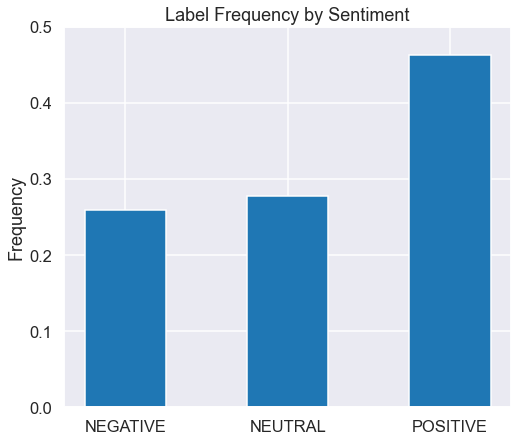

In [105]:
label_counts = corpus.groupby("label").count()["text"]
label_frequencies = label_counts.apply(lambda count: count / label_counts.sum())

fig, ax = plt.subplots(figsize=(8,7))
ax.bar(label_frequencies.index, label_frequencies.values, width=0.5)
ax.set(ylabel="Frequency", title="Label Frequency by Sentiment", ylim=(0,0.5));

# C. *Data Preparation*

In [106]:
import re
import unicodedata
import langdetect 
from nlp_utils import CONTRACTION_MAP, LANGUAGE_CODES
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## C.1 - Cleaning

In [107]:
def preview_documents(corpus, N=20):
    for i in range(N):
        print(corpus.text[i])
        print("---")

### *Replacing Accented Characters*

In [108]:
def remove_accented_characters(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [109]:
corpus["text"] = corpus["text"].apply(remove_accented_characters)

In [110]:
preview_documents(corpus)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
---
@Kwesidei not the whole crew 
---
Need a hug 
---
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
---
@Tatiana_K nope they didn't have it 
---
@twittera que me muera ? 
---
spring break in plain city... it's snowing 
---
I just re-pierced my ears 
---
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
---
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
---
@smarrison i woul

### *Expanding Contractions*

In [111]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    def expand_match(contraction):
        match = contraction.group(0)           
        expanded_match = contraction_mapping[match.lower()] 
        if match[0].isupper():
            expanded_match = expanded_match[0].upper() + expanded_match[1:] 
        return expanded_match
    
    contractions_regex = "(" + '|'.join(sorted(contraction_mapping.keys(), key=lambda x: len(x))) + ")"
    contractions_pattern = re.compile(contractions_regex, flags=re.IGNORECASE|re.DOTALL)
    expanded_text = contractions_pattern.sub(expand_match, text)
    if contractions_pattern.search(expanded_text) is None:
        return expanded_text
    return contractions_pattern.sub(expand_match, expanded_text)

In [112]:
corpus["text"] =  corpus["text"].apply(expand_contractions)

In [113]:
preview_documents(corpus)

@switchfoot http://twitpic.com/2y1zl - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
@nationwideclass no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---
@Kwesidei not the whole crew 
---
Need a hug 
---
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I am fine thanks , how is you ?
---
@Tatiana_K nope they did not have it 
---
@twittera que me muera ? 
---
spring break in plain city... it is snowing 
---
I just re-pierced my ears 
---
@caregiving I could not bear to watch it.  And I thought the UA loss was embarrassing . . . . .
---
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
---
@smarri

### *Removing Twitter Handles*

In [114]:
def remove_twitter_handles(text, addressee_only=True):
    twitter_handle_regex = "^@\w+" if addressee_only else "@\w+"  
    twitter_handle_pattern = re.compile(twitter_handle_regex, flags=re.IGNORECASE|re.DOTALL)
    return twitter_handle_pattern.sub('', text)

In [115]:
corpus["text"] =  corpus["text"].apply(remove_twitter_handles)

In [116]:
preview_documents(corpus)

 http://twitpic.com/2y1zl - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
 I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---
 not the whole crew 
---
Need a hug 
---
 hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I am fine thanks , how is you ?
---
 nope they did not have it 
---
 que me muera ? 
---
spring break in plain city... it is snowing 
---
I just re-pierced my ears 
---
 I could not bear to watch it.  And I thought the UA loss was embarrassing . . . . .
---
 It it counts, idk why I did either. you never talk to me anymore 
---
 i would have been the first, but i did not have a gun.    not really though, zac snyder's just a douc

### *Removing Web Addresses*

In [117]:
def remove_web_addresses(text):
    web_address_regex = "(https?\:\/\/\S+)|(w{3}\.\S+\.(com|org|gov|edu)\S*)"
    web_address_pattern = re.compile(web_address_regex, flags=re.IGNORECASE|re.DOTALL)
    return web_address_pattern.sub('', text)

In [118]:
corpus["text"] =  corpus["text"].apply(remove_web_addresses)

In [119]:
preview_documents(corpus)

  - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
 I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---
 not the whole crew 
---
Need a hug 
---
 hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I am fine thanks , how is you ?
---
 nope they did not have it 
---
 que me muera ? 
---
spring break in plain city... it is snowing 
---
I just re-pierced my ears 
---
 I could not bear to watch it.  And I thought the UA loss was embarrassing . . . . .
---
 It it counts, idk why I did either. you never talk to me anymore 
---
 i would have been the first, but i did not have a gun.    not really though, zac snyder's just a doucheclown.
---
 I wish I g

### *Removing Special Characters*

In [120]:
def remove_special_characters(text):
    return re.sub('[^a-zA-z0-9\s]', '', text)

In [121]:
corpus["text"] =  corpus["text"].apply(remove_special_characters)

In [122]:
preview_documents(corpus)

   Awww that is a bummer  You shoulda got David Carr of Third Day to do it D
---
is upset that he cannot update his Facebook by texting it and might cry as a result  School today also Blah
---
 I dived many times for the ball Managed to save 50  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no it is not behaving at all i am mad why am i here because I cannot see you all over there 
---
 not the whole crew 
---
Need a hug 
---
 hey  long time no see Yes Rains a bit only a bit  LOL  I am fine thanks  how is you 
---
 nope they did not have it 
---
 que me muera  
---
spring break in plain city it is snowing 
---
I just repierced my ears 
---
 I could not bear to watch it  And I thought the UA loss was embarrassing     
---
 It it counts idk why I did either you never talk to me anymore 
---
 i would have been the first but i did not have a gun    not really though zac snyders just a doucheclown
---
 I wish I got to watch it with you I miss you and iam

### *Removing Stop Words*

In [123]:
STOPWORDS = set(stopwords.words("english"))

In [124]:
def remove_stopwords(text, stopwords=STOPWORDS):
    tokens = [token.strip() for token in word_tokenize(text)]
    filtered_tokens = list(filter(lambda token: token not in stopwords, tokens))
    return ' '.join(filtered_tokens)    

In [125]:
corpus["text"] =  corpus["text"].apply(remove_stopwords)

In [126]:
preview_documents(corpus)

that is a of to do it
---
is that he can not his by it and as a
---
for the to out of
---
my and its on
---
no it is not at all i am why am i here because can not you all over there
---
not the
---
a
---
no a only a am how is you
---
they did not have it
---
me
---
in it is
---
just my
---
not to it the was
---
it why did you to me
---
i have been the but i did not have a not just a
---
to it with you you and how was the
---
will me to on is not out now
---
about to
---
to the
---
you out of the
---


In [127]:
corpus.to_csv("data/cleaned1_sentiment140")

### *Removing Non-English Tweets*

In [128]:
def detect_language(text, language_codes=LANGUAGE_CODES):
    return language_codes.get(langdetect.detect(text))

In [129]:
corpus["language"] =  corpus["text"].apply(remove_stopwords)

In [130]:
preview_documents(corpus)

that is a of to do it
---
is that he can not his by it and as a
---
for the to out of
---
my and its on
---
no it is not at all i am why am i here because can not you all over there
---
not the
---
a
---
no a only a am how is you
---
they did not have it
---
me
---
in it is
---
just my
---
not to it the was
---
it why did you to me
---
i have been the but i did not have a not just a
---
to it with you you and how was the
---
will me to on is not out now
---
about to
---
to the
---
you out of the
---


In [131]:
corpus.to_csv("data/cleaned2_sentiment140")

## C.2 - Tokenization

In [132]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

In [133]:
corpus["tokenized"] = corpus["text"].map(lambda tweet: tokenizer.tokenize(tweet))
corpus = corpus.loc[:, ["text", "tokenized", "label"]].rename(columns={"text": "raw"}, inplace=True)

In [134]:
corpus.head(10)

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
corpus.to_csv("data/tokenized_sentiment140")

## C.3 - Lemmatization

In [ ]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize(tokens):
    tagged_tokens = pos_tag(tokens, tagset="universal")
    return [lemmatizer.lemmatize(token[0], token[1]) for token in tagged_tokens]

In [ ]:
corpus["tokenized"] =  corpus["tockenized"].apply(lemmatize)

In [ ]:
corpus.head(10)

## C.4 - Vectorization